# 파이토치 사전훈련 모델 사용
- `torchvision`의 `models`를 활용하여 전이학습

- https://pytorch.org/docs/stable/torchvision/models.html

- 코드 출처: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

## modules import

In [1]:
%pip install wget

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import time
import os
import copy

## GPU 설정

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

## 데이터 로드 및 확인

In [9]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# 작동 안되는데 왜인지 모르겠음. 직접 다운로드 받아서 data 폴더에 저장.

'wget'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


## 전처리 설정

In [10]:
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224), 
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                   'val': transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [13]:
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x],
                             batch_size=4,
                             shuffle=True,
                             num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [14]:
print(class_names)

['ants', 'bees']


## 사전훈련된 모델 로드

In [24]:
model_pt = models.resnet18(pretrained=True)

- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000

In [26]:
model_pt

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [28]:
num_ftrs = model_pt.fc.in_features
model_pt.fc = nn.Linear(num_ftrs, 2)

model_pt = model_pt.to(device)

## 손실함수와 옵티마이저

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer_pt = optim.SGD(model_pt.parameters(), lr=0.001, momentum=0.9)

-  7 에폭마다 0.1씩 학습율 감소

In [30]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_pt, step_size=7, gamma=0.1)
# gamma : learning rate decay, 배수. default:0.1

## 모델 학습

- 학습 함수 정의

In [42]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_correct = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_correct.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}\tAccuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [44]:
model_pt = train_model(model_pt, criterion, optimizer_pt, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2168	Accuracy: 0.9385
val Loss: 0.1663	Accuracy: 0.9412

Epoch 1/24
----------
train Loss: 0.2897	Accuracy: 0.8689
val Loss: 0.1546	Accuracy: 0.9477

Epoch 2/24
----------
train Loss: 0.3144	Accuracy: 0.8525
val Loss: 0.1550	Accuracy: 0.9477

Epoch 3/24
----------
train Loss: 0.2965	Accuracy: 0.8566
val Loss: 0.1754	Accuracy: 0.9346

Epoch 4/24
----------
train Loss: 0.2302	Accuracy: 0.9016
val Loss: 0.1643	Accuracy: 0.9412

Epoch 5/24
----------
train Loss: 0.1890	Accuracy: 0.9344
val Loss: 0.1736	Accuracy: 0.9412

Epoch 6/24
----------
train Loss: 0.2849	Accuracy: 0.8730
val Loss: 0.1738	Accuracy: 0.9346

Epoch 7/24
----------
train Loss: 0.3299	Accuracy: 0.8648
val Loss: 0.1844	Accuracy: 0.9346

Epoch 8/24
----------
train Loss: 0.2667	Accuracy: 0.8852
val Loss: 0.1858	Accuracy: 0.9085

Epoch 9/24
----------
train Loss: 0.2714	Accuracy: 0.8730
val Loss: 0.1543	Accuracy: 0.9477

Epoch 10/24
----------
train Loss: 0.3117	Accuracy: 0.8852
val Loss: 0

## 결과 시각화

- 시각화 함수 정의

In [45]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [47]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'. format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

                
    model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


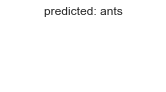

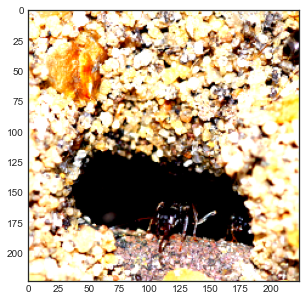

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


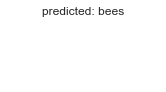

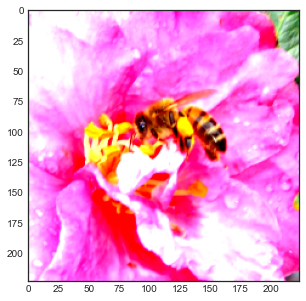

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


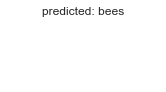

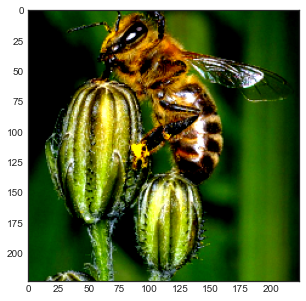

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


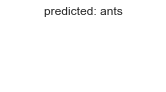

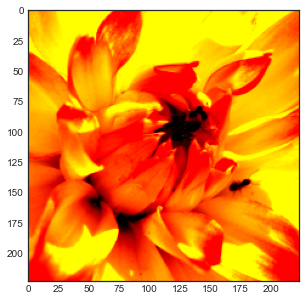

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


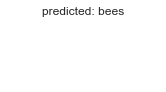

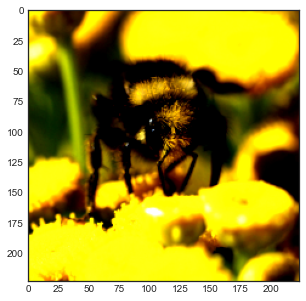

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


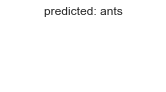

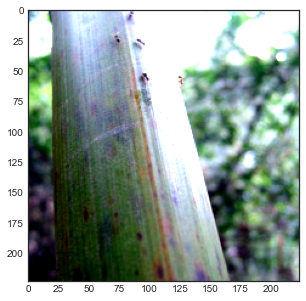

In [48]:
visualize_model(model_pt)

## 고정된 특징 추출기로써의 합성곱 신경망
- 마지막 계층을 제외한 신경망의 모든 부분을 고정

- `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.



In [49]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [50]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6057	Accuracy: 0.6803
val Loss: 0.2938	Accuracy: 0.8954

Epoch 1/24
----------
train Loss: 0.3780	Accuracy: 0.8197
val Loss: 0.2008	Accuracy: 0.9477

Epoch 2/24
----------
train Loss: 0.5442	Accuracy: 0.7500
val Loss: 0.1808	Accuracy: 0.9477

Epoch 3/24
----------
train Loss: 0.4487	Accuracy: 0.8115
val Loss: 0.2926	Accuracy: 0.8889

Epoch 4/24
----------
train Loss: 0.5240	Accuracy: 0.7664
val Loss: 0.2021	Accuracy: 0.9216

Epoch 5/24
----------
train Loss: 0.5556	Accuracy: 0.7951
val Loss: 0.2739	Accuracy: 0.8889

Epoch 6/24
----------
train Loss: 0.5030	Accuracy: 0.7910
val Loss: 0.3080	Accuracy: 0.8824

Epoch 7/24
----------
train Loss: 0.3740	Accuracy: 0.8361
val Loss: 0.1921	Accuracy: 0.9412

Epoch 8/24
----------
train Loss: 0.3292	Accuracy: 0.8648
val Loss: 0.2086	Accuracy: 0.9346

Epoch 9/24
----------
train Loss: 0.3114	Accuracy: 0.8525
val Loss: 0.2022	Accuracy: 0.9477

Epoch 10/24
----------
train Loss: 0.3117	Accuracy: 0.8811
val Loss: 0